In [101]:
import os
import psycopg2
import datetime

import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_palette("bright")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import scipy
import statsmodels.api as sm

from google.colab import auth
from google.cloud import bigquery

# Authenticate to Google Cloud
auth.authenticate_user()

client = bigquery.Client(project='running-342013')

km_in_a_mile = 1.60934

def readConfig(key):
    config = pd.read_csv(r'c:\users\lkave\documents\github\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    dat = client.query(q).to_dataframe()

    return(dat)

In [102]:
user='luke'

In [103]:
ls = ['5Ks', 'half marathons']
dists = [3.11, 13.1]
for n,dist in enumerate(dists):
    dat = dbGetQuery("""SELECT start_date, distance_miles, average_pace, manual as treadmill, minutes_elapsed, name, rank() over (partition by manual, extract(year from start_date) order by minutes_elapsed) as rnk \
                        FROM runs.activities_summary \
                        WHERE distance_miles BETWEEN {} and {} \
                        AND user = '{}'
                        ORDER BY start_date DESC""".format(dist*0.99, dist*1.01, user))
    dat['year'] = [c.year for c in dat.start_date]

    yearly_pr = dat.loc[dat.rnk == 1].copy()

    yearly_pr['pace_mins'] = [int(np.floor(c)) for c in yearly_pr.average_pace]
    yearly_pr['pace_sec'] = [int((c - np.floor(c))*60) for c in yearly_pr.average_pace]
    yearly_pr['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in yearly_pr.minutes_elapsed*60]
    print('*** Best {} by year ***\n'.format(ls[n]))
    display(yearly_pr.sort_values(['treadmill', 'minutes_elapsed'], ascending = True)[['year', 'treadmill', 'pace_mins', 'pace_sec', 'time_mins', 'name']])
    print(' ')

for n,dist in enumerate(dists):
    dat = dbGetQuery("""SELECT CAST(EXTRACT(year from start_date) as int) as yr, distance_miles, average_pace, manual as treadmill, minutes_elapsed, name, rank() over (partition by manual order by minutes_elapsed) as rnk
                        FROM runs.activities_summary
                        WHERE distance_miles BETWEEN {} and {}
                        AND user = '{}'
                        ORDER BY minutes_elapsed ASC
                        LIMIT 20""".format(dist*0.99, dist*1.01, user))

    dat['pace_mins'] = [int(np.floor(c)) for c in dat.average_pace]
    dat['pace_sec'] = [int((c - np.floor(c))*60) for c in dat.average_pace]
    dat['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in dat.minutes_elapsed*60]
    print('*** Best {} all time ***\n'.format(ls[n]))
    display(dat[['yr', 'treadmill', 'pace_mins', 'pace_sec', 'time_mins', 'name']])
    print(' ')

print('*** 50 States Progress ***\n')
df = dbGetQuery("""
SELECT name, start_date as date, average_pace, minutes_elapsed, total_elevation_gain * 3.28084 as total_elevation_gain
FROM runs.activities_summary
WHERE name LIKE 'State #%'
AND user = '{}'
ORDER BY name DESC
""".format(user))

df['pace_mins'] = [int(np.floor(c)) for c in df.average_pace]
df['pace_sec'] = [int((c - np.floor(c))*60) for c in df.average_pace]
df['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in df.minutes_elapsed*60]

display(df[['name', 'date', 'pace_mins', 'pace_sec', 'total_elevation_gain', 'time_mins']])

*** Best 5Ks by year ***



,year,treadmill,pace_mins,pace_sec,time_mins,name
98,2016,0,6,40,00:20:39,Morning Run
113,2014,0,6,45,00:21:13,"09/20/2014 San Francisco, California"
141,2012,0,6,50,00:21:20,Hot Chocolate 5k
49,2019,0,6,55,00:21:38,22 min goal: obliterated!
108,2015,0,7,2,00:21:56,"01/11/2015 San Francisco, California"
127,2013,0,7,6,00:22:04,"07/13/2013 Brooklyn, New York"
2,2025,0,7,20,00:22:55,AGSS 5k
15,2021,0,7,58,00:24:51,Rowed on WaterRower
27,2020,0,8,22,00:26:07,VDOT virtual 5k
77,2017,0,8,12,00:26:13,Morning Run


 
*** Best half marathons by year ***



,year,treadmill,pace_mins,pace_sec,time_mins,name
12,2015,0,7,33,01:39:22,"05/24/2015 Ventura, California"
17,2013,0,7,52,01:43:39,Brooklyn Half 2013
19,2012,0,8,10,01:47:07,Fayetteville Half Marathon
7,2019,0,8,9,01:47:22,Trimara Holiday Half
3,2022,0,8,9,01:47:46,"State #2: Route 66 Half Marathon, Tulsa OK"
15,2014,0,8,38,01:53:50,Urban Cow Half
6,2020,0,8,46,01:57:08,Knoxville Half substitute
2,2023,0,9,2,01:57:33,"State #4: Mine Hill Half Marathon, CT"
11,2018,0,8,55,01:57:39,Morning Run
1,2025,0,9,1,01:59:32,"State #8: Zion Half Marathon, UT"


 
*** Best 5Ks all time ***



,yr,treadmill,pace_mins,pace_sec,time_mins,name
0,2016,1,6,21,00:19:51,SUB-20 TREADMILL 5K
1,2019,1,6,35,00:20:35,Evening Run
2,2016,0,6,40,00:20:39,Morning Run
3,2019,1,6,41,00:20:45,Evening Run
4,2016,0,6,48,00:21:01,Morning Run
5,2013,1,6,47,00:21:02,05/06/2013
6,2014,0,6,45,00:21:13,"09/20/2014 San Francisco, California"
7,2012,0,6,50,00:21:20,Hot Chocolate 5k
8,2019,1,6,53,00:21:25,Evening Run
9,2019,1,6,57,00:21:33,Morning Run


 
*** Best half marathons all time ***



,yr,treadmill,pace_mins,pace_sec,time_mins,name
0,2015,0,7,33,01:39:22,"05/24/2015 Ventura, California"
1,2015,0,7,48,01:42:48,"03/15/2015 West Sacramento, California"
2,2013,0,7,52,01:43:39,Brooklyn Half 2013
3,2013,0,8,1,01:45:19,"09/01/2013 Westwood, New Jersey"
4,2012,0,8,10,01:47:07,Fayetteville Half Marathon
5,2019,0,8,9,01:47:22,Trimara Holiday Half
6,2022,0,8,9,01:47:46,"State #2: Route 66 Half Marathon, Tulsa OK"
7,2015,0,8,18,01:49:49,"02/01/2015 San Francisco, California"
8,2014,0,8,38,01:53:50,Urban Cow Half
9,2012,0,8,38,01:54:11,NYRR Brooklyn Half Marathon


 
*** 50 States Progress ***



,name,date,pace_mins,pace_sec,total_elevation_gain,time_mins
0,"State #8: Zion Half Marathon, UT",2025-03-01 07:00:56+00:00,9,1,574.14700,01:59:32
1,"State #7: Miami Half Marathon, FL",2025-02-02 06:13:21+00:00,10,4,147.63780,02:14:13
2,"State #6: Philadelphia Half Marathon, PA",2023-11-18 07:22:17+00:00,8,39,334.64568,01:55:05
3,"State #5: NYCRUNS Newport Liberty Half, NJ",2023-09-23 08:40:50+00:00,8,46,200.13124,01:56:19
4,"State #4: Mine Hill Half Marathon, CT",2023-05-28 08:45:03+00:00,9,2,1207.34912,01:57:33
5,"State #3: Flying Pig half marathon, Cincinnati OH",2023-05-07 06:36:44+00:00,8,46,613.51708,01:56:45
6,"State #2: Route 66 Half Marathon, Tulsa OK",2022-11-20 08:00:40+00:00,8,9,511.81104,01:47:46
7,"State #1: NYCRUNS Brooklyn Half, Brooklyn NY",2022-04-24 07:42:40+00:00,8,57,400.26248,01:58:25


# YTD activities

In [104]:
dat = dbGetQuery("""SELECT * FROM runs.activities_summary WHERE lower(type) = 'run' AND user = '{}' ORDER BY start_date""".format(user))
display(dat[['user', 'name', 'start_date', 'distance_miles', 'average_pace', 'manual', 'type']].tail(10))

,user,name,start_date,distance_miles,average_pace,manual,type
1948,luke,Morning Run,2025-12-02 06:42:04+00:00,6.938869,8.387195,0,Run
1949,luke,Morning Run,2025-12-03 06:42:51+00:00,4.381672,9.375127,0,Run
1950,luke,Morning Run,2025-12-05 06:43:03+00:00,3.899922,9.179412,0,Run
1951,luke,Morning Run,2025-12-06 07:42:08+00:00,6.338623,8.392443,0,Run
1952,luke,Lunch Run,2025-12-07 11:14:01+00:00,2.855953,10.171495,0,Run
1953,luke,Morning Run,2025-12-10 06:43:00+00:00,4.663837,9.417921,0,Run
1954,luke,"Post-wedding ""keep Babs streak going"" run",2025-12-14 13:45:07+00:00,1.110145,11.227384,0,Run
1955,luke,Morning Run,2025-12-19 06:42:00+00:00,3.902904,8.934791,0,Run
1956,luke,Lunch Run,2025-12-20 12:15:08+00:00,10.554451,8.544838,0,Run
1957,luke,Bit of a tempo,2025-12-21 14:22:42+00:00,5.232704,7.794901,0,Run


In [105]:
dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]

dat['distance_miles'] = [c for c in dat.distance_miles]
dat['ytd_distance'] = dat.groupby('year', as_index = False)['distance_miles'].cumsum()
dat['generic_date'] = [datetime.date(1904,c.month,c.day) for c in dat.start_date]

In [106]:
target = 1000

dat = dat[['start_date', 'generic_date', 'year', 'ytd_distance', 'distance_miles', 'doy']]

actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'].item()

plot_dat = dat[['generic_date', 'year', 'ytd_distance']]
plot_dat = plot_dat.groupby(['generic_date', 'year'], as_index = False).max()
plot_dat = plot_dat.pivot_table(index = 'generic_date', columns = 'year')
plot_dat.columns = plot_dat.columns.droplevel().rename(None)
plot_dat = plot_dat.reset_index()
plot_dat = plot_dat.apply(lambda series: series.loc[:series.last_valid_index()].ffill())

x = range(len(plot_dat))
y = [(target / len(plot_dat)) * x for x in x]
plot_dat['target'] = y
t = datetime.datetime.today().date()
today_target = plot_dat.loc[plot_dat.generic_date == datetime.date(1904, t.month, t.day), 'target'].item()

In [107]:
lin = plot_dat[['generic_date', t.year]].copy()
lin = lin.where(lin.ffill().notna(), 0)
a = np.where(pd.isnull(lin[t.year]))[0][0]
b = np.where(lin.generic_date == datetime.datetime.today().replace(year = 1904).date())[0][0]
lin.loc[a:b, t.year] = lin.loc[a-1, t.year]

y = list(lin.loc[~pd.isnull(lin[t.year]), t.year])
x = list(range(len(y)))
w = x[::-1]
w = [np.exp(-c/10) for c in w]
x = sm.add_constant(x)
m = sm.WLS(y, x, w)
results = m.fit()
lin['pred'] = [c*results.params[1] + results.params[0] for c in list(lin.index)]
lin.loc[lin.pred < 0, 'pred'] = np.nan

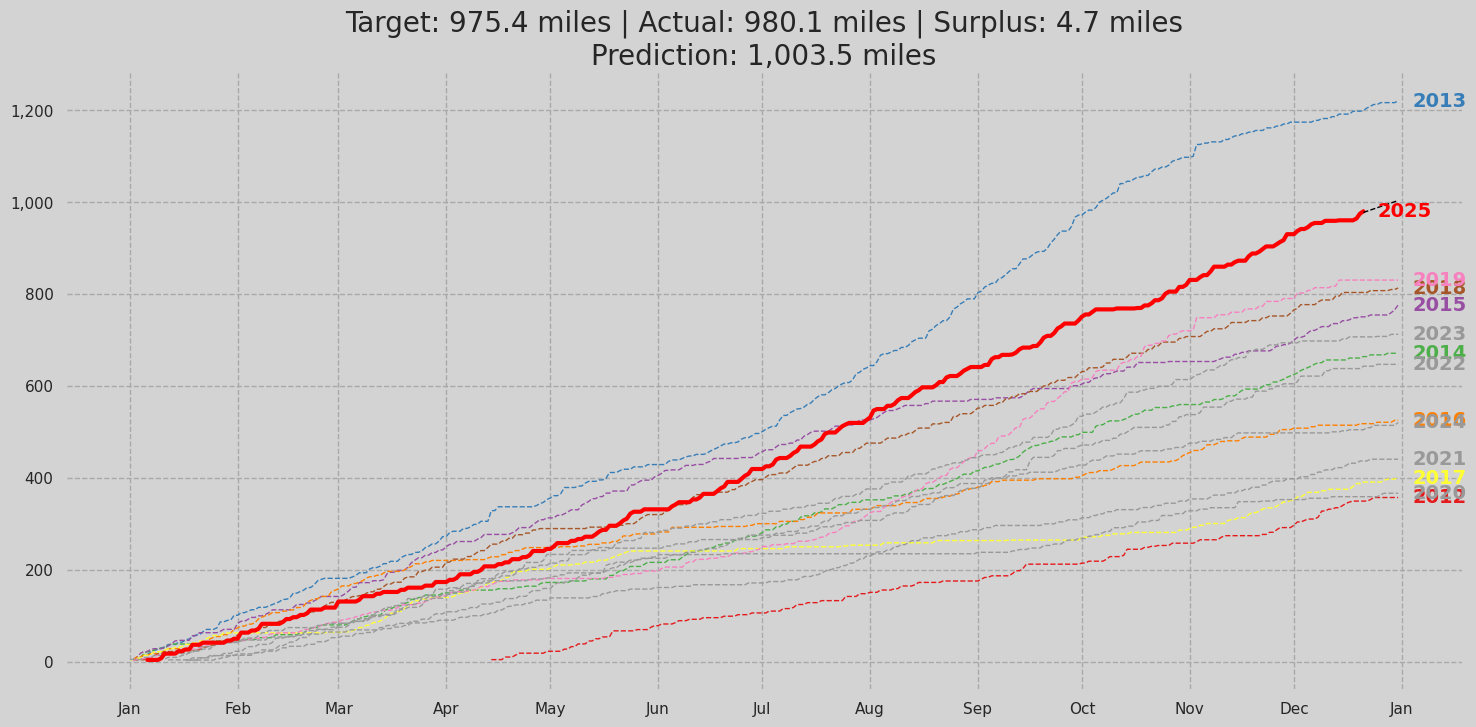

In [108]:
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)

colors = cm.Set1
for n,y in enumerate(plot_dat.columns[1:]):
    if y == 'target':
        continue
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k', linewidth = 2)
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Target', ha = 'left', va = 'center', fontweight = 'bold', color = 'k', fontsize = 14)
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
        ax.text(max(plot_dat.loc[~pd.isnull(plot_dat[y]), 'generic_date'])+datetime.timedelta(4), np.nanmax(plot_dat[y]), y, ha = 'left', va = 'center', fontweight = 'bold', color = 'red', fontsize = 14)
        currentdate = plot_dat.loc[plot_dat[y] == np.nanmax(plot_dat[y]), 'generic_date'].item()
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y].ffill(), linestyle = '--', linewidth = 1, color = colors(n))
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), y, ha = 'left', va = 'center', fontweight = 'bold', color = colors(n), fontsize = 14)

ax.plot(lin.loc[lin.generic_date >= currentdate, 'generic_date'], lin.loc[lin.generic_date >= currentdate, 'pred'], linestyle = '--', linewidth = 1, color = 'black')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_title('Target: {:,.1f} miles | Actual: {:,.1f} miles | Surplus: {:,.1f} miles\nPrediction: {:,.1f} miles'.format(today_target, actual, actual - today_target, lin.tail(1).pred.item()), fontsize = 20)
# ax.set_title('Miles so far this year: {:,.1f}\nPredicted miles for this year: {:,.1f}'.format(actual, lin.tail(1).pred.item()), fontsize = 20)

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])
xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(float(y))))

Text(0.5, 1.0, 'Rolling 30 day mileage')

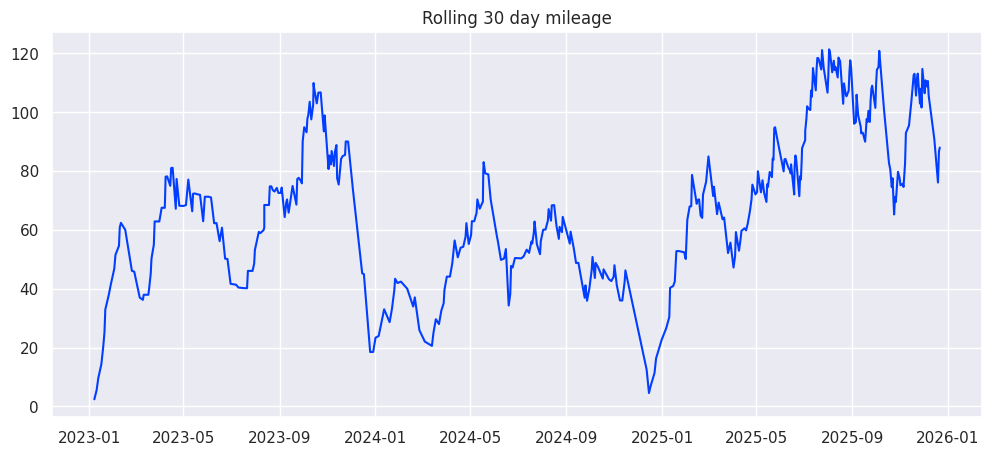

In [109]:
dat = dbGetQuery("""
    WITH raws AS (
        SELECT user
            , start_date
            , distance_miles
        FROM runs.activities_summary
        WHERE lower(type) = 'run'
        AND user = '{}'
        AND start_date >= '2023-01-01'
    )

    SELECT r1.start_date, sum(r2.distance_miles) as distance_miles
    FROM raws r1
    JOIN raws r2
    ON r2.start_date BETWEEN DATE_SUB(r1.start_date, interval 30 day) AND r1.start_date
    GROUP BY 1
    ORDER BY 1
""".format(user))

_, ax = plt.subplots(figsize = (12,5))
ax.plot(dat.start_date, dat.distance_miles)
ax.set_title('Rolling 30 day mileage')

# Miles by weekday

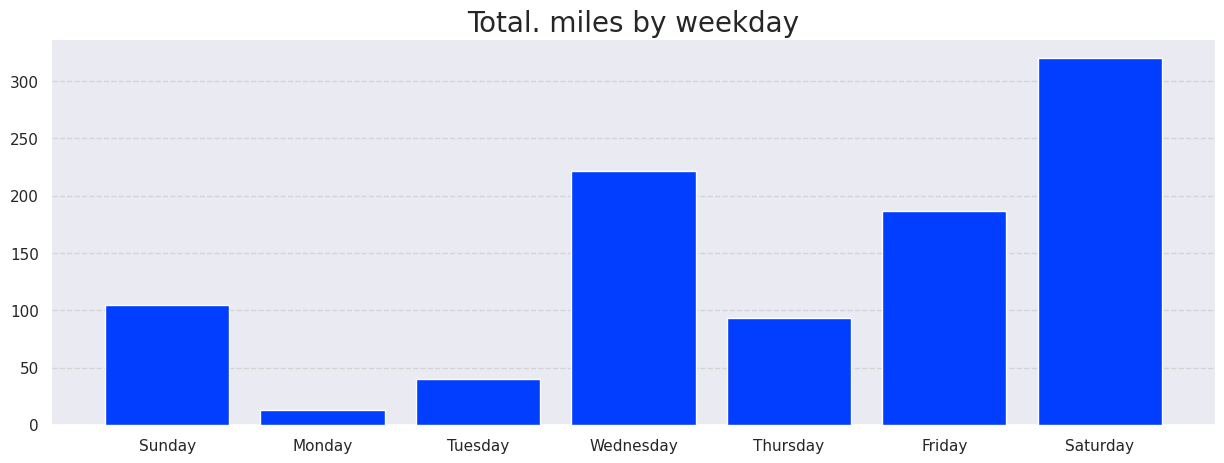

In [110]:
dat = dbGetQuery("""SELECT EXTRACT(dayofweek from start_date) as dow, sum(distance_miles) as total_miles \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                AND lower(type) = 'run'
                AND user = '{}'
                GROUP BY 1 \
                ORDER BY 1""".format(user))

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.total_miles, zorder = 3)


for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Total. miles by weekday', fontsize = 20)
ax.set_xticks(range(1,8,1))
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Average pace

In [111]:
dat = dbGetQuery("""SELECT start_date, average_speed, distance
                    FROM runs.activities \
                    WHERE lower(type) = 'run'
                    AND user = '{}'
                    and average_speed > 2""".format(user))
dat = dat.sort_values('start_date').reset_index(drop = True)
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat['average_pace'] = [(km_in_a_mile/60)/((0.00001+c) / 1000) for c in dat.average_speed]
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

dat['year'] = [c.year for c in dat.start_date]
dat['distance_pace'] = dat['distance'] * dat['average_pace']
yearly = dat.groupby('year').agg({'distance': 'sum', 'distance_pace': 'sum'})
yearly['average_pace'] = yearly['distance_pace'] / yearly['distance']

(7.5, 9.5)

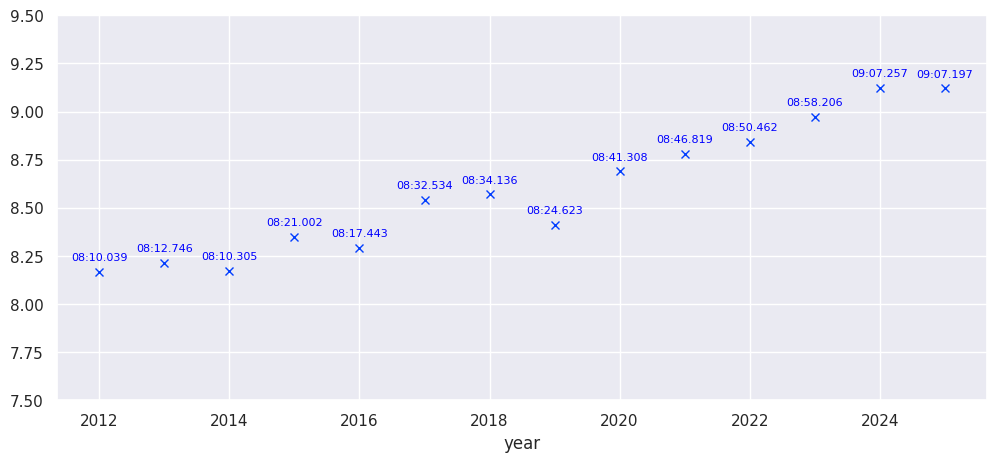

In [112]:
def decimal_to_mmssms(decimal_min):
    minutes = int(decimal_min)
    total_seconds = (decimal_min - minutes) * 60
    seconds = int(total_seconds)
    milliseconds = int(round((total_seconds - seconds) * 1000))
    return f'{minutes:02d}:{seconds:02d}.{milliseconds:03d}'

_, ax = plt.subplots(figsize = (12,5))
yearly['average_pace'].plot(kind='line', ax=ax, marker='x', ls='')

for x, y in enumerate(yearly['average_pace']):
  ax.text(yearly.index[x], y+0.05, f'{decimal_to_mmssms(y)}', ha='center', va='bottom', color='blue', size=8)  # adjust va to move text above/below marker

ax.set_ylim(7.5,9.5)

In [113]:
out = pd.DataFrame(columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD'])

for i in range(len(dat)):
    dat_7 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(7)))]
    dat_30 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(30)))]
    dat_YTD = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= pd.Timestamp(datetime.date(dat.start_date[i].year,1,1), tz='UTC'))]

    pace_y = pace_30 = pace_YTD = None
    if len(dat_7) > 0:
        pace_7 = np.nansum(dat_7.distance * dat_7.average_pace) / np.nansum(dat_7.distance)
    if len(dat_30) > 0:
        pace_30 = np.nansum(dat_30.distance * dat_30.average_pace) / np.nansum(dat_30.distance)
    if len(dat_YTD) > 0:
        pace_YTD = np.nansum(dat_YTD.distance * dat_YTD.average_pace) / np.nansum(dat_YTD.distance)

    out = pd.concat([
        out,
        pd.DataFrame([[dat.start_date[i].date(),
                            pace_7,
                            pace_30,
                            pace_YTD]], columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD']
                         )
    ])
out = out.sort_values('date')

/tmp/ipython-input-2067179008.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([


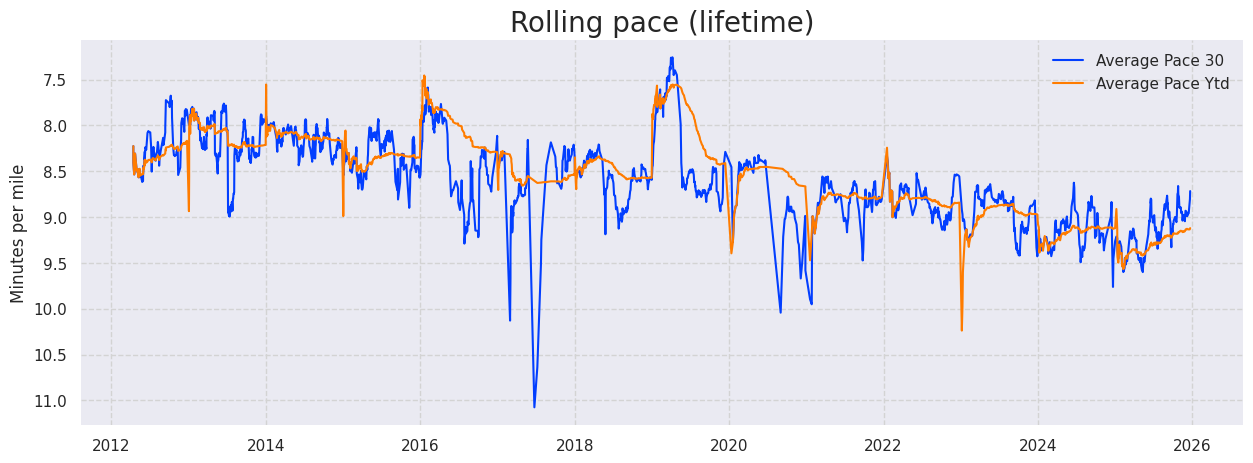

In [114]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[2:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_title('Rolling pace (lifetime)', fontsize = 20)
# ax.set_ylim(7, 10)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

In [115]:
def dec_to_time(d):
    a = int(np.floor(d))
    b = d - np.floor(d)

    b = int(b * 60)
    return(f'{a:2.0f}:{b:02.0f}')

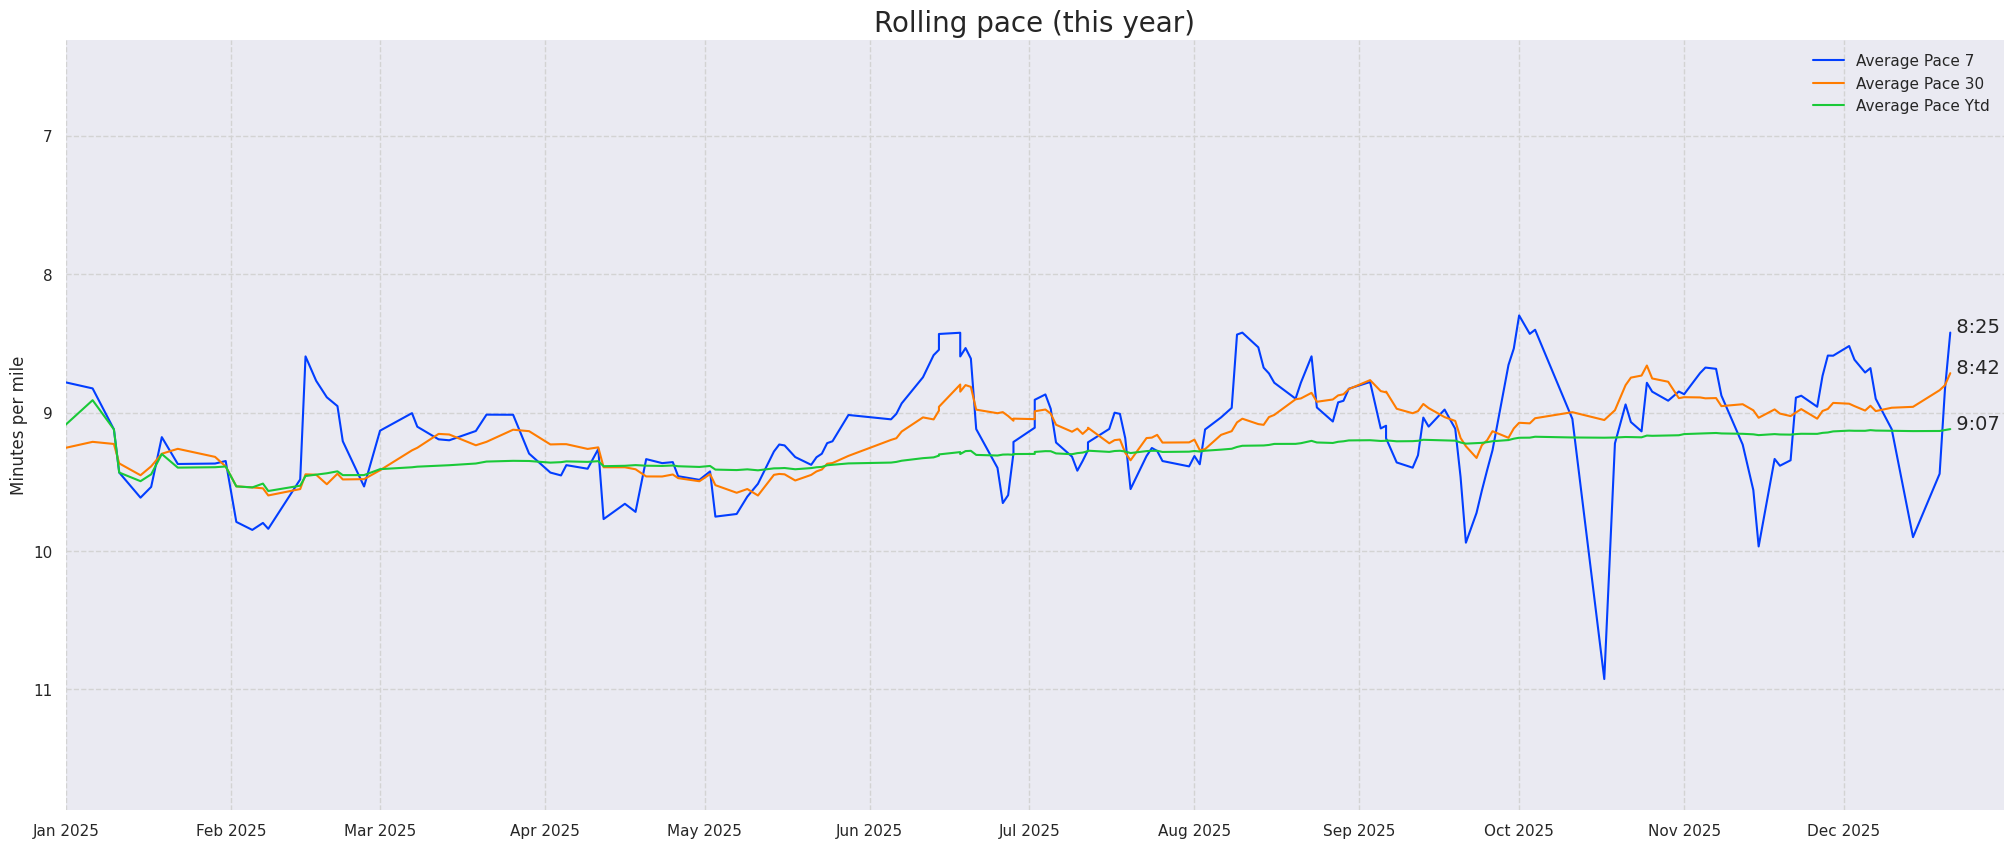

In [116]:
fig = plt.figure(figsize = (25,10))
ax = fig.add_subplot(111)

for y in out.columns[1:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title('Rolling pace (this year)', fontsize = 20)
ax.set_xlim(datetime.date(max(out.date).year, 1, 1), datetime.date(max(out.date).year, 12, 31))
# ax.set_ylim(7,10)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

x = out.tail(1)['date'][0]
y = out.tail(1)['average_pace_7'][0]
ax.text(x = x, y = y, s = dec_to_time(y), fontsize=14)
y = out.tail(1)['average_pace_30'][0]
ax.text(x = x, y = y, s = dec_to_time(y), fontsize=14)
y = out.tail(1)['average_pace_YTD'][0]
ax.text(x = x, y = y, s = dec_to_time(y), fontsize=14)

# ax.plot([datetime.date(2019,1,1), datetime.date(2019,12,31)], [6.4, 6.4], color = 'red', linestyle = '--')
# ax.text(x = datetime.date(2019,1,1), y = 6.3, s = 'Race pace goal', color = 'red')

xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)

## High mileage weeks

In [124]:
lim = 35

dat = dbGetQuery("""SELECT start_date, distance_miles FROM runs.activities_summary WHERE lower(type) = 'run'""")
dat = dat.sort_values('start_date')
dat['weeknum'] = [(c - datetime.timedelta(c.weekday())).date() for c in dat.start_date]
dat = dat.groupby('weeknum', as_index = False)['distance_miles'].sum()
dat = dat.sort_values('weeknum')
dat = dat.loc[dat.distance_miles >= lim]
dat.weeknum = [c.strftime("%d %b, '%y") for c in dat.weeknum]
dat = dat.reset_index(drop = True)

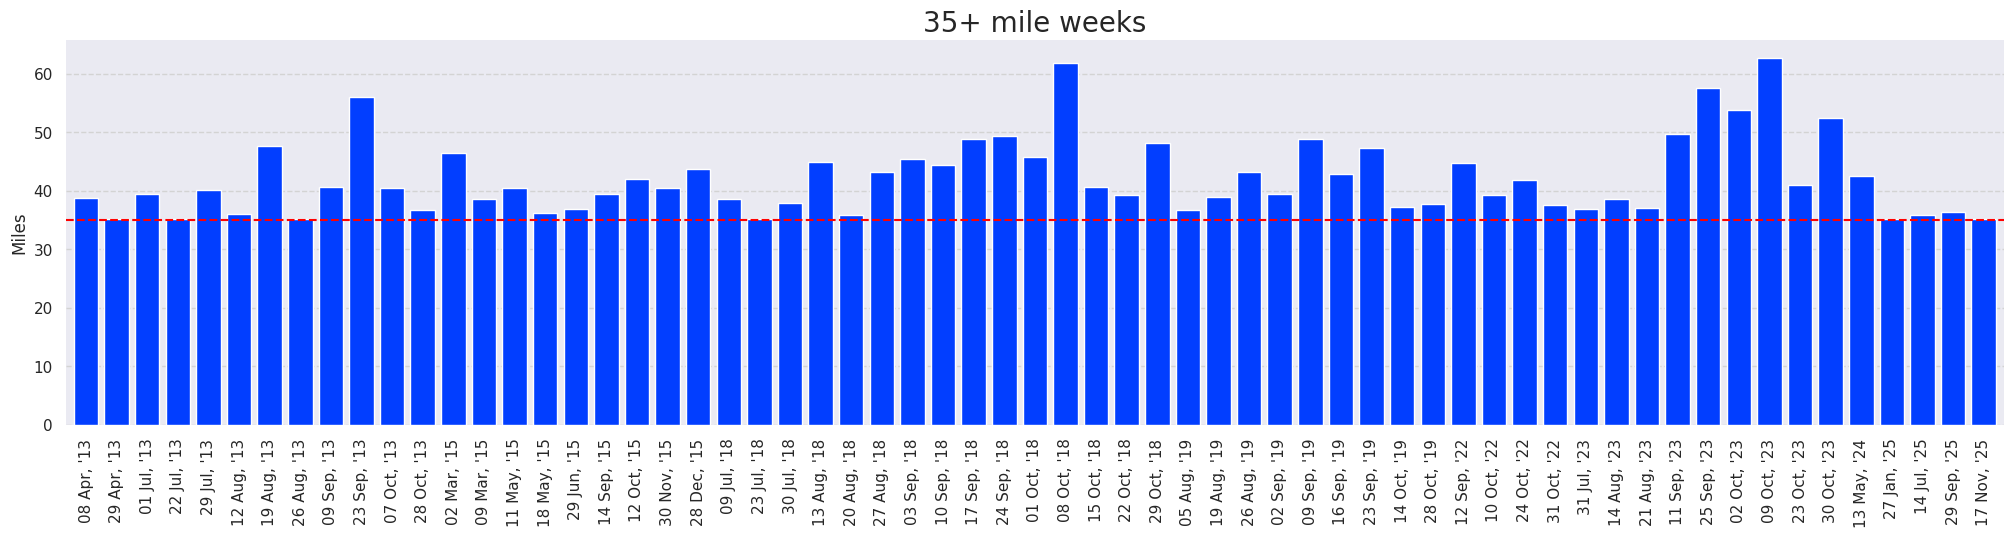

In [125]:
fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)

dat = dat.set_index('weeknum')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('{}+ mile weeks'.format(lim), fontsize = 20)

ax.axhline(lim, color = 'red', ls = '--')
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly elevation gain

In [127]:
dat = dbGetQuery("""SELECT start_date, total_elevation_gain * 3.28084 as total_elevation_gain FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False)['total_elevation_gain'].sum()
dat = dat.sort_values('month')

dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

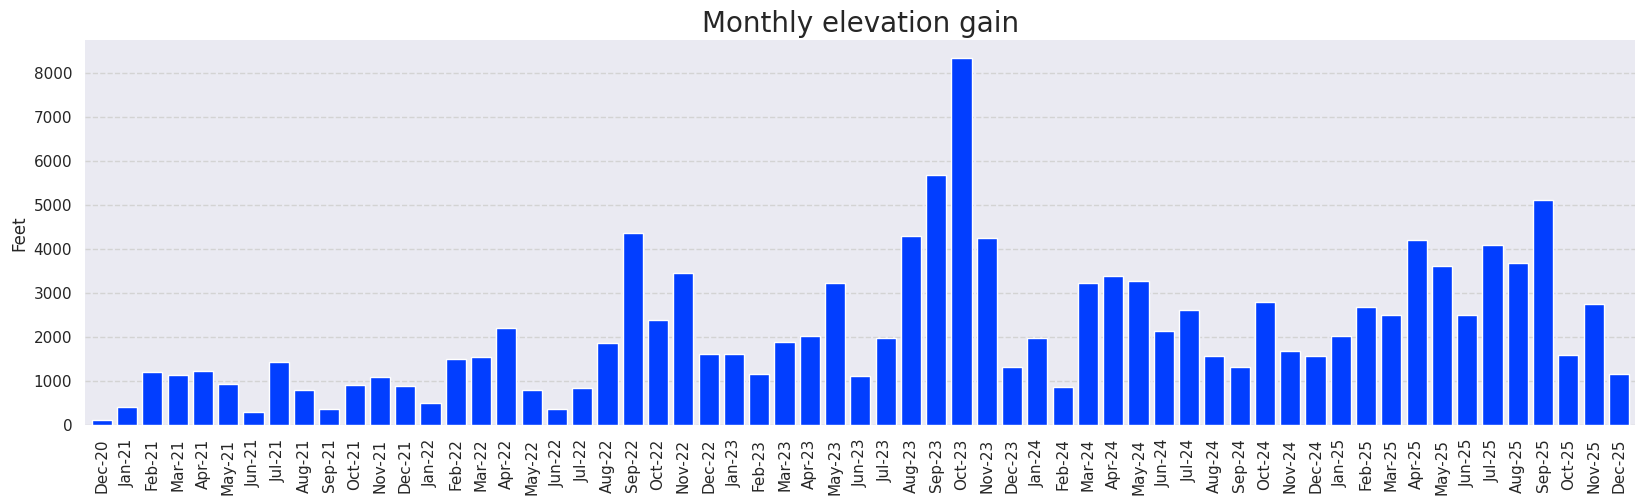

In [128]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Feet')
ax.set_title('Monthly elevation gain', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly mileage

In [129]:
dat = dbGetQuery("""SELECT start_date, distance FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False)['distance'].sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)
dat = dat.set_index('month')

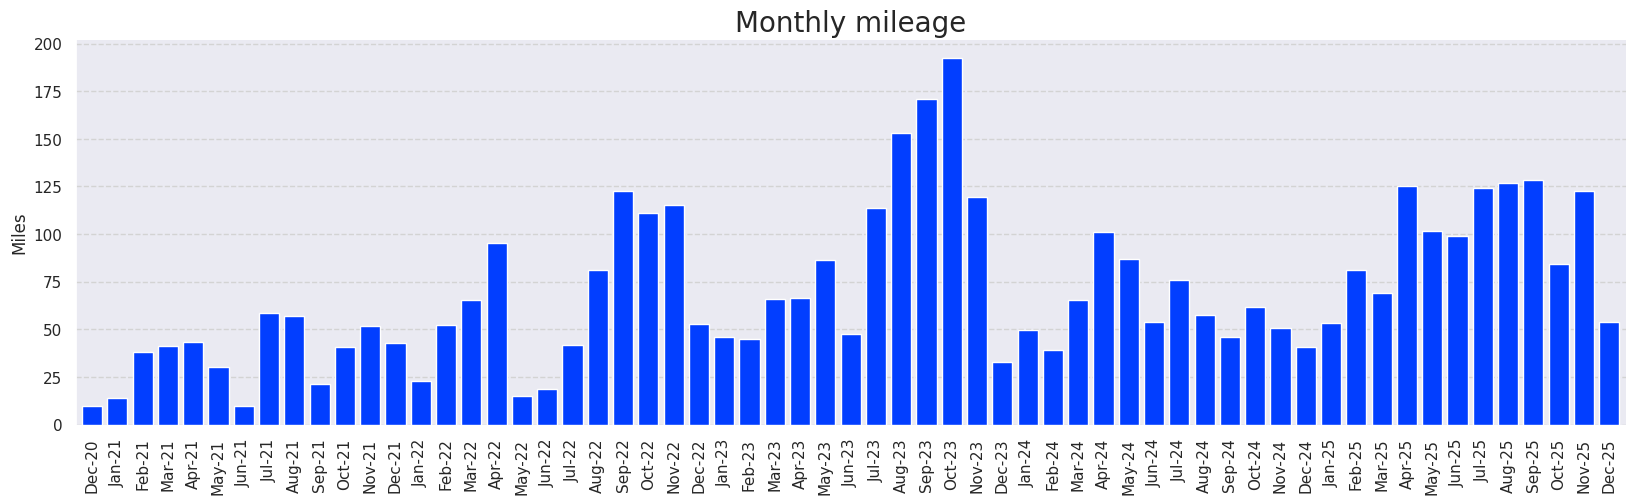

In [130]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('Monthly mileage', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

## Monthly elevation rate (feet of elevation per mile run)

In [135]:
dat = dbGetQuery("""SELECT start_date, (total_elevation_gain * 3.28084) as total_elevation_gain, distance FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [136]:
dat['elevation_rate'] = dat.total_elevation_gain / dat.distance
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat[['month', 'total_elevation_gain', 'distance', 'elevation_rate']]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)
dat = dat.set_index('month')
#dat = dat[['elevation_rate']]

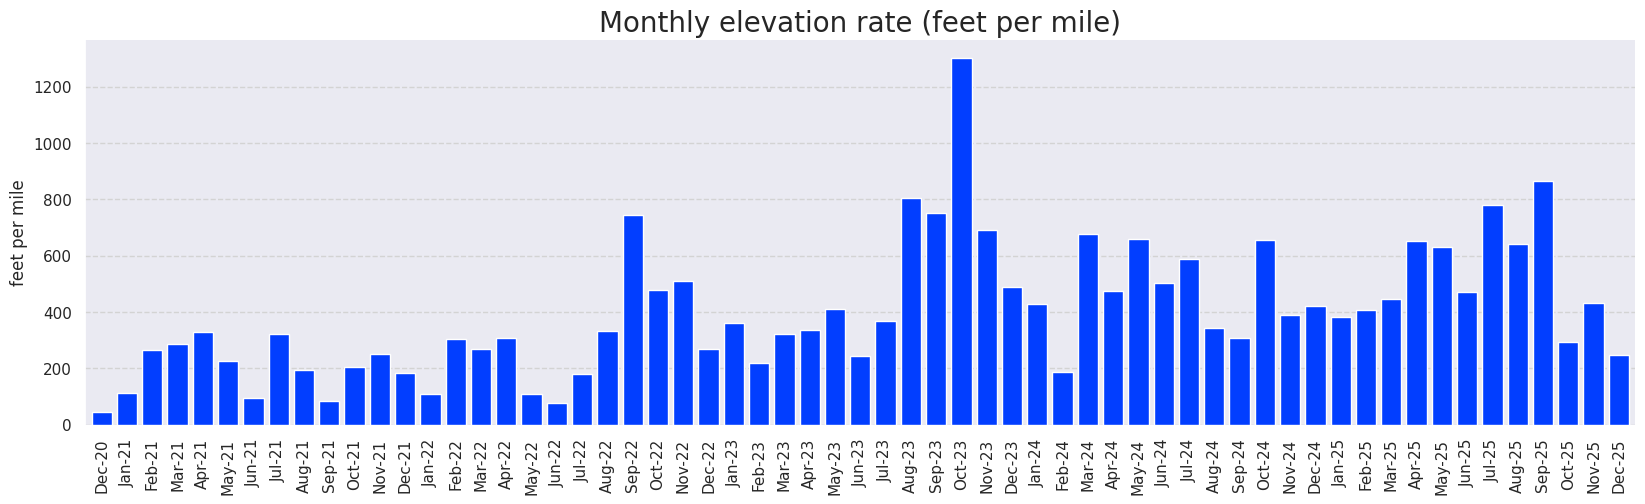

In [137]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat.elevation_rate.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('feet per mile')
ax.set_title('Monthly elevation rate (feet per mile)', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

## Cadence

In [165]:
dat = dbGetQuery("""
    SELECT *
    FROM runs.activities_summary
    WHERE date(start_date) > date_sub(current_date, interval 5 year)
    AND type = 'Run'
    AND average_cadence IS NOT NULL
    ORDER BY start_date ASC""")

dat['cadence_adj'] = dat.average_cadence / dat.average_pace

dat['rolling_weighted_avg_cadence'] = None
window = 14
for i in range(window, len(dat), 1):
    x = dat.average_cadence[(i-window):(i+1)]
    y = dat.distance_miles[(i-window):(i+1)]
    y = y / sum(y)
    wavg = sum([a*b for a,b in zip(x,y)])
    dat.loc[i, 'rolling_weighted_avg_cadence'] = wavg

dat.tail()

,user,start_date,distance_miles,minutes_elapsed,average_pace,average_cadence,total_elevation_gain,manual,name,type,cadence_adj,rolling_weighted_avg_cadence
837,luke,2025-12-14 13:45:07+00:00,1.110145,12.666667,11.227384,161.2,8.0,0,"Post-wedding ""keep Babs streak going"" run",Run,14.357752,167.648543
838,barbara,2025-12-14 13:45:07+00:00,1.229324,12.683333,10.113964,173.0,8.0,0,Strava world tour - Dubai!,Run,17.105064,167.543335
839,luke,2025-12-19 06:42:00+00:00,3.902904,48.616667,8.934791,164.4,40.0,0,Morning Run,Run,18.399982,167.330417
840,luke,2025-12-20 12:15:08+00:00,10.554451,94.483333,8.544838,166.0,36.0,0,Lunch Run,Run,19.426933,167.261879
841,luke,2025-12-21 14:22:42+00:00,5.232704,43.133333,7.794901,167.0,37.0,0,Bit of a tempo,Run,21.424261,167.155452


/tmp/ipython-input-799603969.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


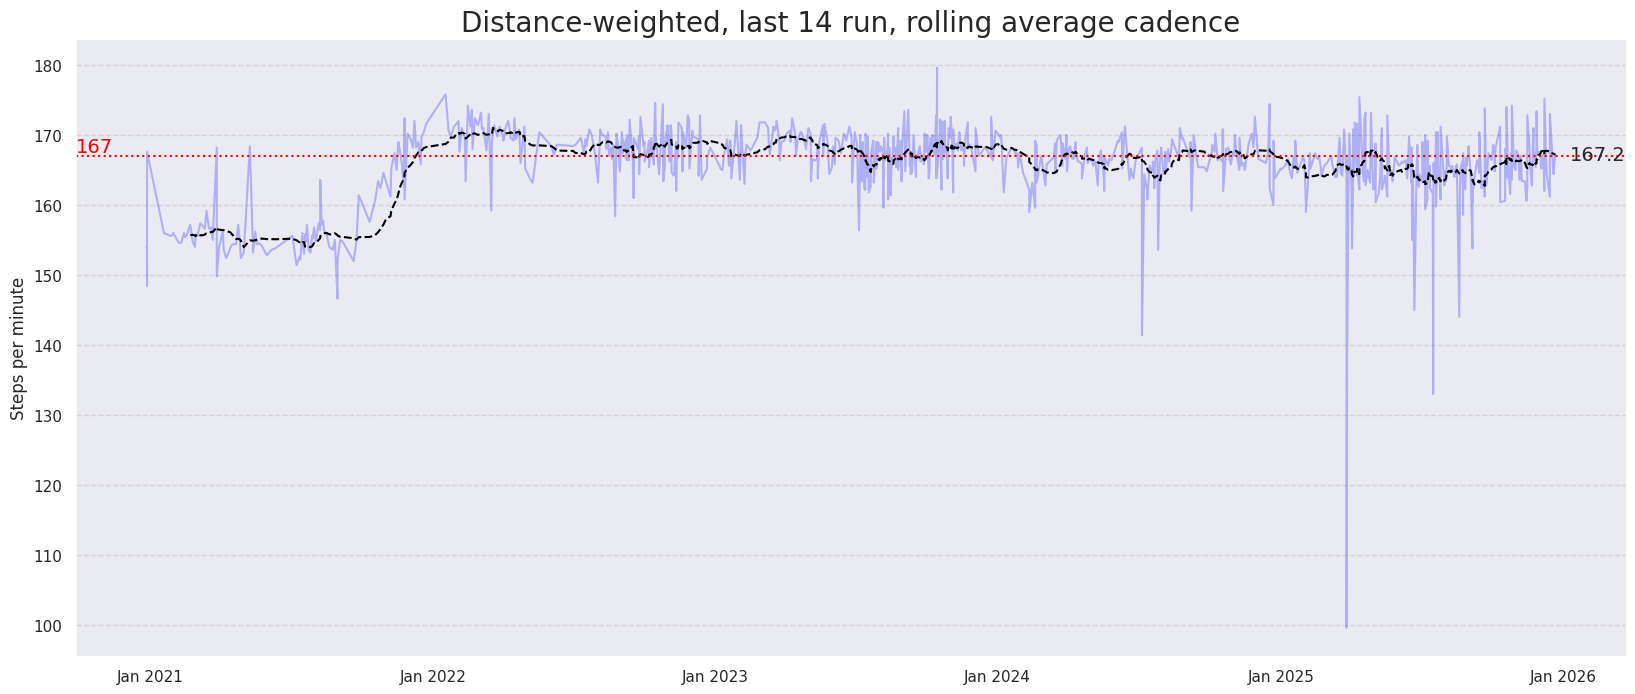

In [167]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)

ax.plot(dat.start_date, dat.average_cadence, color = 'blue', alpha=0.25)
# ax.plot(dat.start_date, dat.rolling_avg_cadence, color = 'black', ls = '--')
ax.plot(dat.start_date, dat.rolling_weighted_avg_cadence, color = 'black', ls = '--')

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.axhline(167, color = 'red', ls = ':')
ax.text(ax.get_xlim()[0], 167, '167', color = 'red', fontsize = 14, ha = 'left', va = 'bottom')
ax.text(ax.get_xlim()[1], dat.rolling_weighted_avg_cadence[len(dat)-1], '{:,.1f}'.format(dat.rolling_weighted_avg_cadence[len(dat)-1]), fontsize = 14, ha = 'right', va = 'center')
# ax.text(ax.get_xlim()[1], dat.average_cadence[len(dat)-1], '{:,.1f}'.format(dat.average_cadence[len(dat)-1]), fontsize = 14, ha = 'right', va = 'center', color = 'blue')
ax.set_xlabel('')
ax.set_ylabel('Steps per minute')
ax.set_title(f'Distance-weighted, last {window} run, rolling average cadence', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.grid(False)